# EWB paper Figure 2: Observations 

We provide the exact code used to generate each figure in order to be completely reproducible and to encourage others to use EWB with their own models quickly. 
This is Figure 2, it shows all of the cases using an outline and then highlights the observations available for each inside

In [ ]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
import urllib.request
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from extremeweatherbench import evaluate, utils, cases, defaults
sns.set_theme(style='whitegrid')
from shapely.geometry import Polygon
import shapely
from typing import Optional, Union, Literal
import xarray as xr
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
from skimage.measure import find_contours

from pathlib import Path

# make the basepath - change this to your local path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'

In [8]:
# load in all of the events in the yaml file
case_dict = utils.load_events_yaml()

# turn the dictionary into a list of case objects
ewb_cases = cases.load_individual_cases(case_dict)

# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(case_dict, defaults.BRIGHTBAND_EVALUATION_OBJECTS)
case_operators = [n for n in case_operators if n.case_metadata.event_type == 'tropical_cyclone']

This function is deprecated and will be removed in a future release. Please use cases.load_ewb_events_yaml_into_case_collection instead.
This function is deprecated and will be removed in a future release. Please use cases.read_incoming_yaml instead.


In [9]:
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor
# load in all the case info (note this takes awhile in non-parallel form as it has to run all the target information for each case)
# this will return a list of tuples with the case id and the target dataset

parallel = Parallel(n_jobs=10,return_as='generator',backend='loky')
case_operators_with_targets_established_generator = parallel(
    delayed(lambda co: (co.case_metadata.case_id_number, evaluate.run_pipeline(co.case_metadata, co.target)))(case_operator) 
    for case_operator in case_operators
)
case_operators_with_targets_established = list(case_operators_with_targets_established_generator)
# this will throw a bunch of errors below but they're not consequential. this releases the memory as it shuts down the workers
# now that they're not used
get_reusable_executor().shutdown(wait=True)

Exception ignored in: <function ResourceTracker.__del__ at 0x7f34378df740>
Traceback (most recent call last):
  File "/home/taylor/.local/share/uv/python/cpython-3.13.3-linux-x86_64-gnu/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/taylor/.local/share/uv/python/cpython-3.13.3-linux-x86_64-gnu/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/taylor/.local/share/uv/python/cpython-3.13.3-linux-x86_64-gnu/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/home/taylor/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x7f1063803740>
Traceback (most recent call last):
  Fi

In [18]:
# helper functions to make the main plotting function cleaner
# helper function to convert a bounding box tuple to a shapely Polygon
def get_polygon_from_bounding_box(bounding_box):
    """Convert a bounding box tuple to a shapely Polygon."""
    if bounding_box is None:
        return None
    left_lon, right_lon, bot_lat, top_lat = bounding_box
    return Polygon(
        [
            (left_lon, bot_lat),
            (right_lon, bot_lat),
            (right_lon, top_lat),
            (left_lon, top_lat),
            (left_lon, bot_lat),
        ]
    )

# helper function to plot a polygon on a cartopy axis
def plot_polygon_outline(polygon, ax, color='yellow', alpha=0.5, my_zorder=1):
    """Plot a shapely Polygon on a Cartopy axis."""
    if polygon is None:
        return
    patch = patches.Polygon(
        polygon.exterior.coords,
        closed=True,
        facecolor='none',
        edgecolor=color,
        alpha=alpha,
        zorder=my_zorder,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(patch)

# main plotting function for plotting all cases
def plot_all_cases_and_obs(ewb_cases, event_type=None, filename=None, bounding_box=None, targets=None, show_orig_pph=False, case_id=None):
    """A function to plot all cases (outlined) and observations (filled) on a world map.
    Args:
        ewb_cases (list): A list of cases to plot.
        event_type (str): The type of event to plot. If None, all events will be plotted).
        filename (str): The name of the file to save the plot. If None, the plot will not be saved.
        bounding_box (tuple): A tuple of the form (min_lon, min_lat, max_lon, max_lat) to set the bounding box for the plot. If None, the full world map will be plotted.
        targets (dict): A dictionary containing observation metadata for each case, such as PPH and LSR reports.
    """
    # plot all cases on one giant world map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # plot the full map or a subset if bounding_box is specified
    if (bounding_box is None):
        ax.set_global()
    else:
        ax.set_extent(bounding_box, crs=ccrs.PlateCarree())
    
    # save the bounding box polygon to subset the counts later
    if (bounding_box is not None):
        bounding_box_polygon = get_polygon_from_bounding_box(bounding_box)
        #plot_polygon(bounding_box_polygon, ax, color='yellow', alpha=0.5)
        
    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Define colors for each event type
    event_colors = {
        'heat_wave': 'firebrick',
        'tropical_cyclone': 'darkorange',
        'severe_convection': 'orchid',
        'atmospheric_river': 'mediumseagreen',
        'freeze': 'royalblue',
        
    }

    # Initialize counts for each event type
    counts_by_type = dict({'freeze': 0, 'heat_wave': 0, 'severe_convection': 0, 'atmospheric_river': 0, 'tropical_cyclone': 0})
    zorders = {'freeze': 10, 'heat_wave': 9, 'atmospheric_river': 2, 'tropical_cyclone': 1, 'severe_convection': 0}
    alphas = {'freeze': 0.9, 'heat_wave': 0.9, 'atmospheric_river': 0.8, 'tropical_cyclone': 0.9, 'severe_convection': 0.1}

    # Plot boxes for each case
    for indiv_case in ewb_cases.cases:
        # Get color based on event type
        indiv_event_type = indiv_case.event_type
        color = event_colors.get(indiv_event_type, 'gray')  # Default to gray if event type not found

        # check if the case is inside the bounding box
        if bounding_box is not None:
            if (not shapely.intersects(indiv_case.location.geopandas.geometry[0], bounding_box_polygon)):
                #print(f"Skipping case {indiv_case.case_id_number} as it is outside the bounding box.")
                continue

        # if a specific case id is specified, only plot that case
        if (case_id is not None and indiv_case.case_id_number != case_id):
            continue

        # count the events by type
        counts_by_type[indiv_event_type] += 1

        # Plot the case geopandas info
        if (indiv_event_type == event_type or event_type is None):
            # to handle wrapping around the prime meridian, we can't use geopandas plot (and besides it is slow)
            # instead we have multi-polygon patches if it wraps around and we need to plot each polygon separately
            if isinstance(indiv_case.location.geopandas.geometry.iloc[0], shapely.geometry.MultiPolygon):
                for poly in indiv_case.location.geopandas.geometry.iloc[0].geoms:
                    plot_polygon_outline(poly, ax, color=color, alpha=alphas[indiv_event_type], my_zorder=zorders[indiv_event_type])
            else:
                plot_polygon_outline(indiv_case.location.geopandas.geometry.iloc[0], ax, color=color, 
                                        alpha=alphas[indiv_event_type], my_zorder=zorders[indiv_event_type])
                
            # grab the target data for this case
            my_target_info = [n[1] for n in targets if n[0] == indiv_case.case_id_number and n[1].attrs['source'] != 'ERA5']

            # make a scatter plot of the target points (for hot/cold events)
            if (indiv_event_type in ['heat_wave', 'freeze', 'tropical_cyclone'] and len(my_target_info) > 0):
                # Get the sparse array data
                data = my_target_info[0]
                
                lat_values = data['latitude'].values
                lon_values = data['longitude'].values

                # Convert longitude values from 0-360 to -180 to 180 for proper 
                # antimeridian handling with Cartopy
                lon_values_180 = utils.convert_longitude_to_180(lon_values)

                # if (np.min(lat_values) <= 0):
                #     print(data)

                ax.scatter(lon_values_180, lat_values, color=color, s=1, alpha=alphas[indiv_event_type], 
                            transform=ccrs.Geodetic(), zorder=zorders[indiv_event_type])

        # # if it is convective, show the PPH and LSRs
        # if (indiv_event_type == 'severe_convection'):
        #     if (case_id is not None and indiv_case.case_id_number != case_id and obs is not None):
        #         continue

        #     # Make sure reports are visible by increasing size and using a distinctive color
        #     # Convert string coordinates to float before plotting
        #     colors = {'tor': 'red','wind': 'blue', 'hail': 'black'}
        #     markers= {'tor': 'o', 'wind': 's', 'hail': '^'}  

        #     # Define zorder values to control plotting order (higher values appear on top)
        #     zorders = {'tor': 10, 'wind': 9, 'hail': 8}
            
        #     # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
        #     # Create a custom sort order where 'tor' comes last
        #     sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
        #     sorted_df = obs[indiv_case.case_id_number]['lsr_reports'].copy()
        #     sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
            
        #     # Group by report type and plot each group with its own color
        #     for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        #         ax.scatter(group['Longitude'].astype(float), group['Latitude'].astype(float), 
        #                 color=colors.get(report_type, 'gray'), s=20, marker=markers.get(report_type), alpha=0.9,
        #                 transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
        #                 zorder=zorders.get(report_type, 10))
                
        #     # Plot the PPH outline
        #     pph = obs[indiv_case.case_id_number]['pph']
            
        #     #print (np.max(pph.values), np.min(pph.values))
            
        #     # find the contour outlines
        #     contours = find_contours(pph.values, level=0.01, fully_connected='low')

        #     for contour in contours:
        #         contour_lon_lat_coords = []
        #         for r_idx, c_idx in contour:
        #             # Ensure indices are integers for array lookup
        #             r_idx_int = int(r_idx)
        #             c_idx_int = int(c_idx)

        #             # Get the corresponding longitude and latitude
        #             lon_val = pph.longitude[c_idx_int]
        #             lat_val = pph.latitude[r_idx_int]
        #             contour_lon_lat_coords.append((lon_val, lat_val))

        #         # Convert to a NumPy array for easier handling if needed
        #         contour_lon_lat_coords = np.array(contour_lon_lat_coords)
        #         #print(contour_lon_lat_coords)

        #         # convert from array indices to lat/lon
        #         patch = patches.Polygon(contour_lon_lat_coords, closed=True, facecolor='none', 
        #                                 edgecolor=event_colors['severe_convection'], alpha=1, linewidth=2,
        #                                 transform=ccrs.PlateCarree())
        #         ax.add_patch(patch)
            
        #     if (show_orig_pph):
        #         # Plot the data using contourf
        #         levels = [0.01, .05,.15,.30,.45,.60,.75]  

        #         # Create a custom colormap that sets alpha=0 for values below 0.05
        #         cmap = plt.cm.viridis
        #         norm = mcolors.BoundaryNorm(levels, cmap.N)

        #         # Create the colormap with alpha=0 for values below 0.05
        #         # Create a mask for values below 0.05
        #         mask = np.ma.masked_less(pph, 0.001)
        #         cmap_with_alpha = plt.cm.viridis.copy()
        #         cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

        #         contour = ax.contour(pph.longitude, pph.latitude, mask, 
        #                             levels=levels, transform=ccrs.PlateCarree(),
        #                             cmap=cmap_with_alpha, extend='both')
                

        
    # Create a custom legend for event types
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=event_colors['heat_wave'], alpha=0.9, label='Heat Wave (n = %d)' % counts_by_type['heat_wave']),
        Patch(facecolor=event_colors['freeze'], alpha=0.9, label='Freeze (n = %d)' % counts_by_type['freeze']),
        Patch(facecolor=event_colors['severe_convection'], alpha=0.9, label='Convection (n = %d)' % counts_by_type['severe_convection']),
        Patch(facecolor=event_colors['atmospheric_river'], alpha=0.9, label='Atmospheric River (n = %d)' % counts_by_type['atmospheric_river']),
        Patch(facecolor=event_colors['tropical_cyclone'], alpha=0.9, label='Tropical Cyclone (n = %d)' % counts_by_type['tropical_cyclone']),
    ]
    # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    if (event_type is None):
        title = 'ExtremeWeatherBench Cases (n = %d)' % sum(counts_by_type.values())
    else:
        title = f'ExtremeWeatherBench Cases: {event_type.replace("_", " ").title()} (n = %d)' % counts_by_type[event_type]
    
    ax.set_title(title, loc='left', fontsize=20)
    
    # save if there is a filename specified (otherwise the user just wants to see the plot)
    if filename is not None:
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=300)

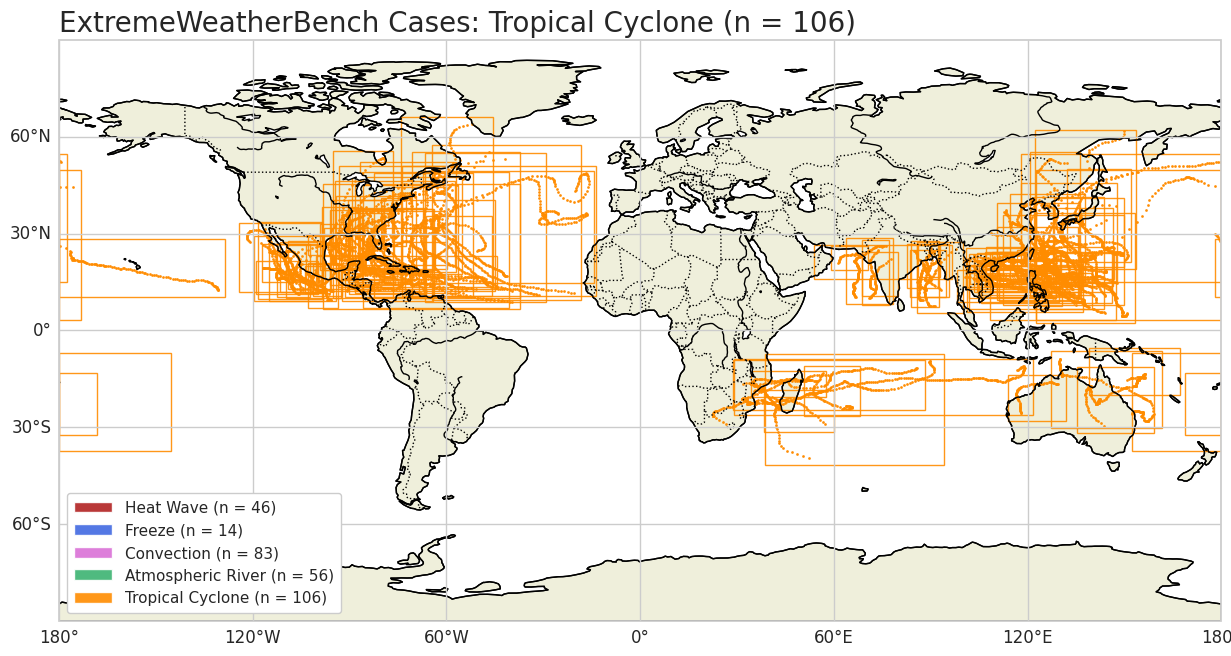

In [19]:
# plot the indivdual cases for each event type
plot_all_cases_and_obs(ewb_cases, event_type='tropical_cyclone', filename=basepath + 'docs/notebooks/figs/ewb_obs_tcs.png', targets=case_operators_with_targets_established)
# plot_all_cases_and_obs(ewb_cases, event_type='freeze', filename=basepath + 'docs/notebooks/figs/ewb_obs_freeze.png', targets=case_operators_with_targets_established)
#plot_all_cases_and_obs(ewb_cases, event_type='heat_wave', filename=basepath + 'docs/notebooks/figs/ewb_obs_heat.png', targets=case_operators_with_targets_established)
#plot_all_cases_and_obs(ewb_cases, event_type='atmospheric_river', filename=basepath + 'docs/notebooks/figs/ewb_obs_ar.png')
#plot_all_cases_and_obs(ewb_cases, event_type='severe_convection', filename=basepath + 'docs/notebooks/figs/ewb_obs_convective.png')

# # plot all cases on one giant world map
# plot_all_cases_and_obs(ewb_cases, event_type=None, filename=basepath + 'docs/notebooks/figs/ewb_obs_all.png')

In [6]:
# install metpy version 1.6.3 for this notebook only
!uv pip install metpy==1.6.3

Audited 1 package in 64ms


In [10]:
# This is modified from the original code for CONUS to work with Australian LSR data
def extract_lsr_data_australia(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. We pull all reorts within 1 day. If date is none, we return all reports
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data with columns lat, lon, report_type, time, and scale.
    """

    aus_file = "gs://extremeweatherbench/datasets/AustralianLSRData_2020-2024.csv"

    # Read the CSV files with all columns to identify report types
    try:
        df = pd.read_csv(aus_file, delimiter=',', engine='python', storage_options=dict(token="anon"), parse_dates=['Date/Time UTC'], date_format='%Y-%m-%d %H:%M:%S')
    except Exception as e:
        print(f'Error pulling hail data for {date}: {e}')
        return pd.DataFrame()

    # if date is none, presumably we want all reports
    if (date == None):
        return df

    # Filter the DataFrame for the specified date range
    start_date = date - pd.Timedelta(days=0.5)    
    end_date = date + pd.Timedelta(days=0.5)
    df = df[(df['Date/Time UTC'] >= start_date) & (df['Date/Time UTC'] < end_date)]
    if len(df) == 0:
        print(f'No LSR data found for {date}')
        return pd.DataFrame()
    return df

In [11]:
def practically_perfect_hindcast_aus(
    date: pd.Timestamp,
    resolution: float = 0.25,
    report_type: Union[Literal["all"], list[Literal["tor", "hail", "wind"]]] = "all",
    sigma: float = 1.5,
    return_reports: bool = False,
    output_resolution: Optional[float] = None,
    report_constants = {'hail': 15, 'tor': 5}
) -> Union[xr.DataArray, tuple[xr.DataArray, pd.DataFrame]]:
    """Compute the Practically Perfect Hindcast (PPH) using storm report data using latitude/longitude grid spacing
    instead of the NCEP 212 Eta Lambert Conformal projection; based on the method described in Hitchens et al 2013,
    https://doi.org/10.1175/WAF-D-12-00113.1

    Args:
        date: A pandas Timestamp object.
        resolution: The resolution of the grid to use. Default is 0.25 degrees.
        report_type: The type of report to use. Default is all. Currently only supports all.
        sigma: The sigma (standard deviation) of the gaussian filter to use. Default is 1.5.
        return_reports: Whether to return the reports used to compute the PPH. Default is False.
        output_resolution: The resolution of the output grid. Default is None (keep the same resolution as the input grid).
        report_constants: A dictionary mapping report types to their respective values for the PPH grid. Default is {'hail': 15, 'tor': 5}.
    Returns:
        pph: An xarray DataArray containing the PPH around the storm report data.
    """

    df = extract_lsr_data_australia(date)
    if report_type == "all":
        pass
    else:
        df = df[df['report_type'].isin(report_type)]

    # Create a grid covering Australia
    lat_min, lat_max = -50, -10.0   
    lon_min, lon_max = 110, 180  

    # Create the grid coordinates
    grid_lats = np.arange(lat_min, lat_max + resolution, resolution)
    grid_lons = np.arange(lon_min, lon_max + resolution, resolution)

    # Initialize an empty grid
    grid = np.zeros((len(grid_lats), len(grid_lons)))

    # extract reports for TOR and HAIL separately to handle the underreporting
    for report_type in report_constants.keys():
        # Filter the dataframe for the current report type
        df2 = df[df['report_type'] == report_type]

        # Extract latitude and longitude from the dataframe
        lats = df2["Latitude"].astype(float)
        lons = df2["Longitude"].astype(float)

        # Mark grid cells that contain reports
        for lat, lon in zip(lats, lons):
            # Find the nearest grid indices
            lat_idx = np.abs(grid_lats - lat).argmin()
            lon_idx = np.abs(grid_lons - lon).argmin()
            grid[lat_idx, lon_idx] = report_constants[report_type]  # Set a value to indicate a report is present

    # Create the xarray DataArray
    pph = xr.DataArray(
        grid,
        dims=["latitude", "longitude"],
        coords={"latitude": grid_lats, "longitude": grid_lons},
        name="practically_perfect",
    )

    # Apply bilinear interpolation to smooth the field
    # First, create a gaussian kernel for smoothing
    smoothed_grid = gaussian_filter(grid, sigma=sigma)

    # Replace the data in the DataArray
    pph.data = smoothed_grid
    if output_resolution is not None:
        pph = pph.interp(latitude=np.arange(lat_min, lat_max + output_resolution, output_resolution),
                        longitude=np.arange(lon_min, lon_max + output_resolution, output_resolution),method='linear')
        pph = pph * 100
    if return_reports:
        return (pph, df)
    return pph

In [12]:
# need to pre-compute the obs info and store it in the cases
# I think there should be either 
# 1) a quick way to grab all the metadata on the obs into the case (e.g. through a single function call at the high level) or
# 2) it is already stored into the events yaml (just the locations, but this isn't super extensible if more obs come in later)
# 3) a method call on each individual case to get the metadata
# I'm going with option 3 for now

# Note since there is about to be a big refactor of how events and cases are stored, this is just a temporary hack
events_metadata = {}
for event in cases:
    for indiv_case in event.cases:
        # this is what I want to see for each case
        # commented out because it doesn't exist :) 
        # indiv_case.get_observations_metadata()

        # instead I'll try to hack it
        if (indiv_case.event_type == 'heat_wave' or indiv_case.event_type == 'freeze'):
            # figure our how to find the obs metadata for the heat/freeze events
            #print("Help, not sure how to find the obs locations")
            continue
        elif (indiv_case.event_type == 'severe_convection'):
            # grab the LSRs and compute PPH and then we can plot both the LSRs and the PPH outer outline (up in the plotting function)

            # check if the case is inside the Australia bounding box
            bot_lat = -50
            top_lat = -10
            left_lon = 110
            right_lon = 180
            bounding_box = [left_lon, right_lon, bot_lat, top_lat]
            bounding_box_polygon = get_polygon_from_bounding_box(bounding_box)

            if (shapely.intersects(indiv_case.location.geopandas.geometry[0], bounding_box_polygon)):
                print(indiv_case)
                
                pph, df = practically_perfect_hindcast_aus(indiv_case.start_date, return_reports=True)
                events_metadata[indiv_case.case_id_number] = {'pph': pph, 'lsr_reports': df}

IndividualSevereConvectionCase(case_id_number=266, title='January 2020 Australia', start_date=datetime.datetime(2020, 1, 20, 0, 0), end_date=datetime.datetime(2020, 1, 21, 0, 0), location=BoundingBoxRegion(latitude_min=-40.0, latitude_max=-10.0, longitude_min=110.0, longitude_max=155.0), event_type='severe_convection', data_vars=None, cross_listed=None, metrics_list=[<class 'extremeweatherbench.metrics.RegionalRMSE'>])
IndividualSevereConvectionCase(case_id_number=267, title='April 2020 Australia', start_date=datetime.datetime(2020, 4, 3, 0, 0), end_date=datetime.datetime(2020, 4, 4, 0, 0), location=BoundingBoxRegion(latitude_min=-40.0, latitude_max=-10.0, longitude_min=110.0, longitude_max=155.0), event_type='severe_convection', data_vars=None, cross_listed=None, metrics_list=[<class 'extremeweatherbench.metrics.RegionalRMSE'>])
IndividualSevereConvectionCase(case_id_number=268, title='May 2020 Australia', start_date=datetime.datetime(2020, 5, 31, 0, 0), end_date=datetime.datetime(202

In [ ]:
# plot North America
bot_lat = 7
top_lat = 85
left_lon = -172
right_lon = -45

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
filename = 'docs/notebooks/figs/extreme_weather_cases_NA.png'
plot_title = 'ExtremeWeatherBench Cases in North America'

plot_all_cases_and_obs(cases, event_type=None, bounding_box=bounding_box, filename=filename)

In [ ]:
# plot Europe
bot_lat = 15
top_lat = 75
left_lon = -15
right_lon = 50

print(right_lon, left_lon, bot_lat, top_lat)

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
filename = 'docs/notebooks/fig/extreme_weather_cases_Europe.png'
plot_title = 'ExtremeWeatherBench Cases in Europe'
plot_all_cases_and_obs(cases, event_type=None, bounding_box=bounding_box, filename=filename)

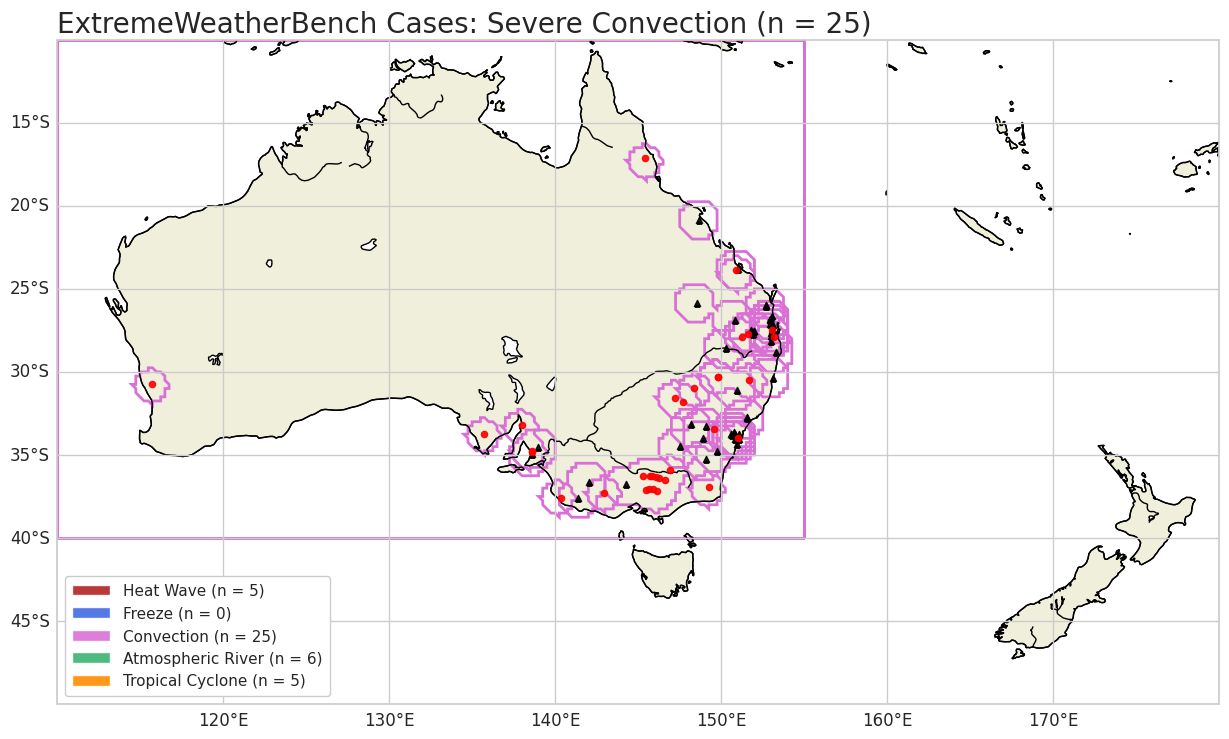

In [13]:
# plot Australia
bot_lat = -50
top_lat = -10
left_lon = 110
right_lon = 180
bounding_box = [left_lon, right_lon, bot_lat, top_lat]
filename = 'docs/notebooks/figs/extreme_weather_cases_Aus.png'
plot_title = 'ExtremeWeatherBench Cases in Australia'

plot_all_cases_and_obs(cases, event_type='severe_convection', bounding_box=bounding_box, filename=filename, obs =events_metadata, show_orig_pph=False)